In [2]:
%matplotlib inline
import os
os.environ['THEANO_FLAGS']='device=gpu0'

import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T
conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer

from lasagne.utils import as_tuple, floatX
from lasagne.random import get_rng
import cv2

NUM_EPOCHS = 11
BATCH_SIZE = 256
LEARNING_RATE = 0.00001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"
#INPUT FILE DEGISTIRILECEK

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
def _linspace(start, stop, num):
    # Theano linspace. Behaves similar to np.linspace
    start = T.cast(start, theano.config.floatX)
    stop = T.cast(stop, theano.config.floatX)
    num = T.cast(num, theano.config.floatX)
    step = (stop-start)/(num-1)
    return T.arange(num, dtype=theano.config.floatX)*step+start

In [4]:
a = T.dscalar()
b = T.dscalar()

c = a + b

f = theano.function([a,b], c)

np.allclose(f(16.3, 12.1), 28.4)

True

In [5]:
print 60 /3
print type(60 //3)

print type(60 //3.1)
print 60 // 3



20
<type 'int'>
<type 'float'>
20


In [6]:
np.set_printoptions(threshold=np.nan)
width = 20
height = 20

x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
                np.linspace(-1, 1, height))
ones = np.ones(np.prod(x_t.shape))
grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])

# print x_t
# print type(grid)
# print grid.dtype
# print grid.shape

In [9]:
downsample_factor = 3.0
downsample_factor = as_tuple(downsample_factor, 2)

print downsample_factor

(3.0, 3.0)


In [10]:
def _transform_affine(theta, input, downsample_factor):
    
    
    num_batch, num_channels, height, width = input.shape
    theta = np.reshape(theta, (-1, 2, 3))
    
    # grid of (x_t, y_t, 1), eq (1) in ref [1]
    out_height = int(height // downsample_factor[0])
    out_width = int(width // downsample_factor[1])
    grid = _meshgrid(out_height, out_width)

    # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
    T_g = np.dot(theta, grid)
    x_s = T_g[:, 0]
    y_s = T_g[:, 1]
    x_s_flat = x_s.flatten()
    y_s_flat = y_s.flatten()

    # dimshuffle input to  (bs, height, width, channels)
    input_dim = input.transpose(0, 2, 3, 1)
    input_transformed = _interpolate(
        input_dim, x_s_flat, y_s_flat,
        out_height, out_width)
 
    
    output = np.reshape(
        input_transformed, (num_batch, out_height, out_width, num_channels))
    output = output.transpose(0, 3, 1, 2)  # dimshuffle to conv format
    return output, T_g

def _meshgrid(height, width):
    x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
                        np.linspace(-1, 1, height))
    ones = np.ones(np.prod(x_t.shape))
    grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
    return grid

def _interpolate(im, x, y, out_height, out_width):
    # *_f are floats
    num_batch, height, width, channels = im.shape
    height_f = float(height)
    width_f = float(width)

    # clip coordinates to [-1, 1]
    x = np.clip(x, -1, 1)
    y = np.clip(y, -1, 1)

    # scale coordinates from [-1, 1] to [0, width/height - 1]
    x = (x + 1) / 2 * (width_f - 1)
    y = (y + 1) / 2 * (height_f - 1)

    # obtain indices of the 2x2 pixel neighborhood surrounding the coordinates;
    # we need those in floatX for interpolation and in int64 for indexing. for
    # indexing, we need to take care they do not extend past the image.
    x0_f = np.floor(x)
    y0_f = np.floor(y)
    x1_f = x0_f + 1
    y1_f = y0_f + 1
    x0 = x0_f.astype("int")
    y0 = y0_f.astype("int")
    
    
    x1 = np.minimum(x1_f, width_f - 1).astype("int")
    y1 = np.minimum(y1_f, height_f - 1).astype("int")

    # The input is [num_batch, height, width, channels]. We do the lookup in
    # the flattened input, i.e [num_batch*height*width, channels]. We need
    # to offset all indices to match the flat version
    dim2 = width
    dim1 = width*height
    base = np.repeat(
        np.arange(num_batch, dtype='int64')*dim1, out_height*out_width)
    base_y0 = base + y0*dim2
    base_y1 = base + y1*dim2
    idx_a = base_y0 + x0
    idx_b = base_y1 + x0
    idx_c = base_y0 + x1
    idx_d = base_y1 + x1

    # use indices to lookup pixels for all samples
    im_flat = im.reshape((-1, channels))
    Ia = im_flat[idx_a]
    Ib = im_flat[idx_b]
    Ic = im_flat[idx_c]
    Id = im_flat[idx_d]

    # calculate interpolated values
    wa = np.expand_dims((x1_f-x) * (y1_f-y), 1)
    wb = np.expand_dims((x1_f-x) * (y-y0_f), 1)
    wc = np.expand_dims((x-x0_f) * (y1_f-y), 1)
    wd = np.expand_dims((x-x0_f) * (y-y0_f), 1)
    
    output = np.sum([wa*Ia, wb*Ib, wc*Ic, wd*Id], axis=0)
    return output


In [88]:
import cv2
test_image = cv2.imread("/home/dontgetdown/Documents/caner_grad/MNIST_IMAGES/10_45_90_derece/10k+10k_test/3/23305.png")
test_image = np.expand_dims(test_image.transpose(2, 0, 1), 0)
print test_image.shape
thetas = [[ 0.49938843,  0.03984484, -0.02736071, -0.03870711,  0.51125753, -0.12223954]]
# thetas = [[ 0.5, 0.5, 0, -0.5,  0.5, 0]]
downsample_factor = (1.0, 1.0)
out_pic = _transform_affine(thetas, test_image, downsample_factor)

(1, 3, 60, 60)


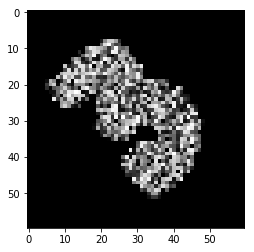

In [94]:
# plt.imshow(out_pic[0][0].transpose(1,2,0), cmap='gray', interpolation='none')
plt.imshow(out_pic[0][0].swapaxes(0, 2).swapaxes(0, 1), cmap='gray', interpolation='none')



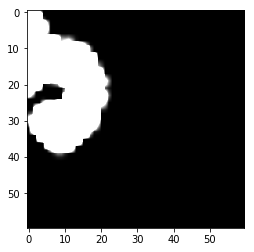

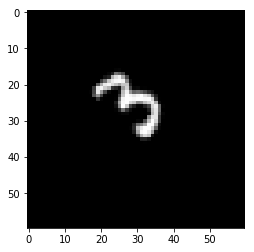

In [33]:
plt.imshow(test_image[0].transpose(1,2,0), cmap='gray', interpolation='none')
